In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import preps, plots, params, feats, strats
importlib.reload(preps)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import json
import re
import os
import psutil

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2023-03-01 08:00:00,147.660,148.3000,147.660,148.300,2058.0,58.0,148.224427,148.3297,148.2703,0.009324,0.009281,147.1860,0.007569,147.087222,0.008245,146.995714,0.008873,147.015600,0.008736,147.055800,0.008461,147.137047,0.007904,147.609288,147.380261,147.230151,147.200594,147.126719,147.066970,147.036695,0.009359,0.008912,0.008706,0.640,0.004334,0.0000,0.000,0.004316,95.763549,89.667377,85.943151,0.188879,0.056999,0.131880,0.089155,-0.000759,0.089914,0.221733,0.001495,0.126024,0.000850,0.076004,0.000513,92.053695,4.327953,32.520657,84.923263,8.696507,23.081063,75.503493,14.146101,19.941382,146.388856,147.601144,0.008247,146.085785,147.904215,0.012371,146.629219,147.401981,0.005256,1.612970e+10,1.081775,1.155183,1.597494,148.30,146.8500,0.000000,0.009777,-3797.0,-25.809490,-4086.5,-27.800130,0.002060,0.001198,0.642857,0.484127,0.550000,0.410317,466.666667,500.000000,62.509210,52.197789,0.206383,0.008946,148.30,146.8500,0.009777,148.30,146.8500,0.009777,147.019185,147.020923,0.019489,0.000357,147.071401,146.927077,147.215725,0.001963,147.071401,146.878969,147.263833,0.002617,146.873275,148.300000
2023-03-01 08:01:00,148.280,148.3000,148.130,148.300,2181.0,60.0,148.261950,148.3297,148.2703,0.000000,0.000000,147.4680,0.005642,147.233889,0.007241,147.057143,0.008452,147.041200,0.008561,147.067600,0.008380,147.142048,0.007870,147.954644,147.686841,147.467895,147.420475,147.294331,147.179063,147.086236,0.009599,0.008946,0.008775,0.020,0.000135,0.0000,0.150,0.001146,95.763549,89.667377,85.943151,0.302525,0.138841,0.163684,0.175043,0.034401,0.140642,0.214342,0.001445,0.129165,0.000871,0.079361,0.000535,81.623698,3.837581,40.877582,76.939599,7.878945,27.248248,69.727198,13.063872,21.673523,146.229327,147.891673,0.011304,145.813740,148.307260,0.016956,146.513335,147.569065,0.007180,1.612970e+10,1.020931,1.160040,1.642091,148.30,146.8500,0.000000,0.009777,-1072.0,-7.277276,-1792.5,-12.189139,0.002059,0.001198,0.857143,0.650794,0.800000,0.569841,250.537875,356.639889,67.537982,55.914099,0.278423,0.076052,148.30,146.8500,0.009777,148.30,146.8500,0.009777,147.106067,147.052278,0.038053,0.003390,147.188410,147.038552,147.338268,0.002036,147.188410,146.988600,147.388221,0.002715,146.900000,148.300000
2023-03-01 08:02:00,148.200,148.3000,148.200,148.300,1173.0,19.0,148.281907,148.3297,148.2703,0.000000,0.000000,147.7460,0.003750,147.379444,0.006246,147.119524,0.008024,147.066800,0.008385,147.078900,0.008302,147.147048,0.007835,148.127322,147.891227,147.652808,147.596380,147.437998,147.280967,147.133835,0.009462,0.008981,0.008912,0.100,0.000675,0.0000,0.000,0.000674,95.763549,89.667377,85.943151,0.359757,0.212480,0.147277,0.240339,0.075589,0.164751,0.198008,0.001335,0.127082,0.000857,0.080098,0.000540,75.734771,3.560710,48.040662,

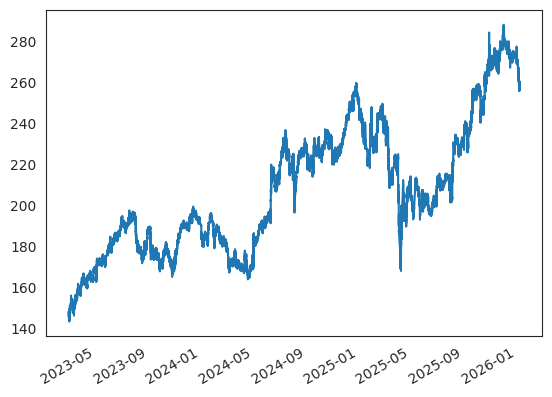

In [3]:
# Read the unscaled indicators dataframe

df = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) 
# df = df[(df.index >= '2021-09-01') & (df.index < '2023-03-01')] #########################
df = df[df.index >= '2020-12-31'] #########################
df.close.plot()
df

In [4]:
col_signal = params.col_signal_tick
sign_thresh = params.sign_thresh_tick

if col_signal == 'signal_raw' and sign_thresh == 'signal_thresh': # running simulation for the target signal
    print('building signals directly into df...')
    df = preps.build_signal_per_day( 
            df              = df, 
            min_prof_thr    = params.min_prof_thr_tick,
            max_down_prop   = params.max_down_prop_tick,
            gain_tightfact  = params.gain_tightfact_tick,
            tau_time        = params.tau_time_tick,
            tau_dur         = params.tau_dur_tick,
            thresh_mode     = params.thresh_mode_tick,
            thresh_window   = params.thresh_window_tick,
    )

first_day = df.index.normalize().min()
start_ask = df.loc[df.index.normalize() == first_day, "ask"].iloc[0]
strats.reset_globals(start_ask)

sim_results = {}
groups = df.groupby(df.index.normalize())
total_days = df.index.normalize().nunique()


for day, df_day_sim in tqdm(groups, desc="Generate+Simulate", total=total_days):
    
    df_actions = strats.generate_actions_alpaca(
        df              = df_day_sim,
        col_signal      = col_signal,
        sign_thresh     = sign_thresh,
        col_atr         = params.col_atr_tick,
        col_adx         = params.col_adx_tick,
        col_rsi         = params.col_rsi_tick,
        col_vwap        = params.col_vwap_tick,
        reset_peak      = params.reset_peak_tick,
        rsi_min_thresh  = params.rsi_min_thresh_tick,
        rsi_max_thresh  = params.rsi_max_thresh_tick,
        atr_mult        = params.atr_mult_tick,
        vwap_atr_mult   = params.vwap_atr_mult_tick,
        adx_thresh      = params.adx_thresh_tick,
        trailstop_pct   = params.trailstop_pct_tick,
        sess_start      = params.sess_premark
    )
    
    sim_results.update(
        strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = params.buy_factor_tick,
            sell_factor = params.sell_factor_tick,
        )
    )

print("Loop finished. Days simulated:", len(sim_results))


Generate+Simulate:   0%|          | 0/719 [00:00<?, ?it/s]

Loop finished. Days simulated: 719


No simulation data for 2021-09
Overall Summary (2023-03-01 = 148.330 → 2026-01-09 = 259.058)
Num. trading days: 719
Trades Count: 43872
Initial capital: 100000.000

One-Time B&H gain: 74614.870 | final: 174614.870 | PnL%: 74.61%
Sum Strategy gain: -7861.019 | final: 92138.981 | PnL%: -7.86%
Sum Intraday gain: -11355.416 | final: 88644.584 | PnL%: -11.36%

One-Time B&H gain per day: 103.7759
Strategy gain per day: -10.9333
Strategy gain per trade: -0.1792


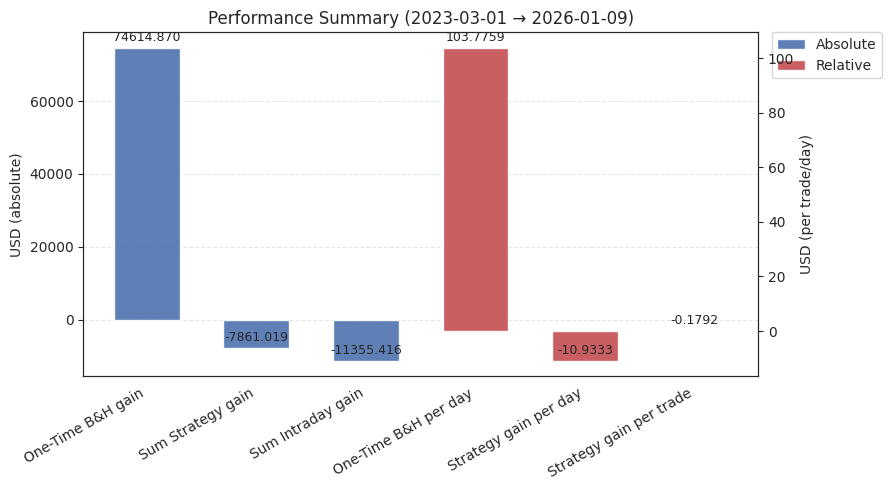

Rolling monthly summary (each metric carries its own capital forward):

Monthly Summary 2023-03 (2023-03-01 = 148.330 → 2023-03-31 = 164.717)
Num. trading days: 23  Trades Count: 1076
One-Time B&H gain: 10983.248 | start: 100000.000 | final: 110983.248 | PnL%: 10.98%
Sum Strategy gain: 4163.372 | start: 100000.000 | final: 104163.372 | PnL%: 4.16%
Sum Intraday gain: 4375.885 | start: 100000.000 | final: 104375.885 | PnL%: 4.38%

Monthly Summary 2023-04 (2023-04-03 = 164.717 → 2023-04-28 = 169.146)
Num. trading days: 19  Trades Count: 1560
One-Time B&H gain: 3369.249 | start: 110983.248 | final: 114352.497 | PnL%: 3.04%
Sum Strategy gain: 292.214 | start: 104163.372 | final: 104455.586 | PnL%: 0.28%
Sum Intraday gain: 3840.547 | start: 104375.885 | final: 108216.432 | PnL%: 3.68%

Monthly Summary 2023-05 (2023-05-01 = 169.146 → 2023-05-31 = 177.724)
Num. trading days: 22  Trades Count: 1161
One-Time B&H gain: 5141.422 | start: 114352.497 | final: 119493.919 | PnL%: 4.50%
Sum Strategy ga

In [5]:
# importlib.reload(params) ######
# importlib.reload(strats) ######
# importlib.reload(plots) ######

year, month = map(int, params.month_to_check.split("-"))
dates_in_month = [date for date in sim_results if date.year == year and date.month == month]

if not dates_in_month:
    print(f"No simulation data for {params.month_to_check}")
else:
    for date in sorted(dates_in_month):
        df_at_date_plot, trades_at_date, stats_at_date = sim_results[date]
        plots.plot_trades(
            df                 = df_at_date_plot,
            col_signal1        = col_signal,
            sign_thresh        = sign_thresh, 
            axis_sig_thresh    = 'second',
            features           = [params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick],
            autoscale          = False
        )
        
        print(f"\n{' ' * 50}******* Performance for {date.strftime('%Y-%m-%d')} *******\n")
        for k,v in stats_at_date.items(): # Print stats dict for each date nicely
            print(f"{k}:\n" + "\n".join("  "+L for L in (v if isinstance(v,list) else str(v).splitlines())))
        print("\n" + "="*160 + "\n")

# final visualizations and monthly aggregations
strats.aggregate_performance(df = df,
                             sim_results = sim_results)


In [1]:
# propose adjusted parameters ranges for next optuna run
from libs import opts
new_ranges = opts.propose_ranges_from_top(
    csv_path="optuna_results/AAPL_97.4739_predicted.csv",
    top_n=30,
    spread=3,
    agg="median",
    cat_top_k=3,
)

new_ranges

{'reset_peak': (0, 0),
 'rsi_min_thresh': (27, 35),
 'rsi_max_thresh': (50, 50),
 'adx_thresh': (54.48213536933162, 54.65967463066837),
 'atr_mult': (16.551936093816696, 18.439403906183305),
 'vwap_atr_mult': (0.6030502094385315, 1.0297097905614685),
 'buy_factor': (0.7726095987344072, 0.8673004012655928),
 'sell_factor': (0.032442553605695895, 0.0424274463943041),
 'trailstop_pct': (19.127797192673505, 32.404702807326494),
 'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}